In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import f1_score

#working with text
from sklearn.feature_extraction.text import TfidfVectorizer

#normalizing data
from sklearn.preprocessing import StandardScaler

#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score, recall_score

#imputer
from sklearn.impute import SimpleImputer

In [3]:
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

## Загружаем датасет.
Датасет состоит из описания вакансий. Целевая переменная ('fraudulent') говорит о том, является ли вакансия фейком или нет.

In [4]:
df = pd.read_csv("./fake_job_postings.csv")
df.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


In [5]:
df['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

Вывод: выборка несбалансированная. Учту при выборе модели.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [7]:
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [8]:
cat_features = ['title', 'location', 'department', 'employment_type',
                'required_experience', 'required_education', 'industry', 'function']
text_features = ['company_profile', 'description', 'requirements', 'benefits']
cont_features = ['salary_range', 'telecommuting', 'has_company_logo', 'has_questions']
target = ['fraudlent']

### Категориальные признаки

In [9]:
#предполагаю,что наличие или отсутствие зарплат (а не цифры), влияет на целевую переменную
df['salary_range_int'] = df['salary_range'].notnull().astype('int')

In [10]:
df['salary_range_int'].value_counts()

0    15012
1     2868
Name: salary_range_int, dtype: int64

In [11]:
def v_c(feat):
    return feat.value_counts()

In [12]:
for i in range(len(cat_features)):
    print(f'{cat_features[i]}:\n {v_c(df[cat_features[i]])}\n')  

title:
 English Teacher Abroad                                                             311
Customer Service Associate                                                         146
Graduates: English Teacher Abroad (Conversational)                                 144
English Teacher Abroad                                                              95
Software Engineer                                                                   86
                                                                                  ... 
Seeking semi tech savvy staff                                                        1
Opening for PHP Developer/ Software Engineer                                         1
Office Experience Manager                                                            1
3 x Pension Transition Relationship Advisor (6 months fixed term)                    1
PR4 2AS Business Admin Apprenticeship available under NAS 16-24 year olds only!      1
Name: title, Length: 11231, dtype: 

### Посмотрим на матрицу корреляций количественных признаков:

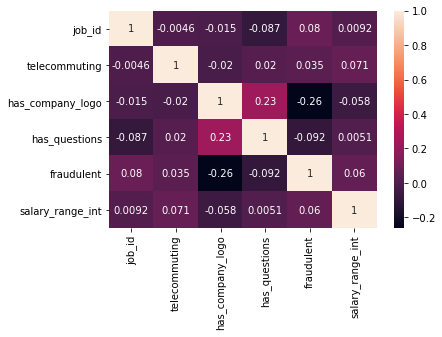

In [13]:
sns.heatmap(df.corr(),annot=True);

возьму в обработку с наибольшей корреляцией 'has_company_logo' и 'has_questions'

In [14]:
cont_features = ['has_company_logo', 'has_questions']

In [15]:
#department, required_experience, required_education не буду брать в обучение (очень большое количество пропусков)
#title распишу отдельно, нет пропусков
text_features = ['company_profile', 'description', 'requirements', 'benefits', 'industry', 'function']

### Pre-processing

In [16]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]    
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]    

class TextImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key, value):
        self.key = key
        self.value = value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.key] = X[self.key].fillna(self.value)
        return X

### разделим на train/test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df, df['fraudulent'],
                                                    test_size=0.33, random_state=42)
# save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)

# save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

In [18]:
final_transformers = list()
    
title = Pipeline([                
                ('selector', ColumnSelector(key='title')),
                ('tfidf', TfidfVectorizer())
            ])
final_transformers.append(('title', title))

for cont in cont_features:
    final_transformer = Pipeline([
                    ('selector',  NumberSelector(key=cont))                     
                ])
    final_transformers.append((cont, final_transformer))
    
for col in text_features:
    final_transformer = Pipeline([
                    ('imputer', TextImputer(col, '')),
                    ('selector', ColumnSelector(key=col)),
                    ('tfidf', TfidfVectorizer())
                ])
    final_transformers.append((col, final_transformer))

In [19]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [20]:
feats

FeatureUnion(transformer_list=[('title',
                                Pipeline(steps=[('selector',
                                                 ColumnSelector(key='title')),
                                                ('tfidf', TfidfVectorizer())])),
                               ('has_company_logo',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='has_company_logo'))])),
                               ('has_questions',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='has_questions'))])),
                               ('company_profile',
                                Pipeline(steps=[('imputer',...
                                                 ColumnSelector(key='benefits')),
                                                ('tfidf', TfidfVectorizer())])),
                               ('industry',
                                Pipeline(steps=[('imputer',
                                                 TextImputer(key='industry',
                                                             value='')),
                                                ('selector',
                                                 ColumnSelector(key='industry')),
                                                ('tfidf', TfidfVectorizer())])),
                               ('function',
                                Pipeline(steps=[('imputer',
                                                 TextImputer(key='function',
                                                             value='')),
                                                ('selector',
                                                 ColumnSelector(key='function')),
                                                ('tfidf',
                                                 TfidfVectorizer())]))])

In [21]:
pd.options.mode.chained_assignment = None
feature_processing.fit(X_train)

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('title',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(key='title')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('has_company_logo',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='has_company_logo'))])),
                                                ('has_questions',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='has_questions'))])),
                                                ('company_profile',
                                                 Pi...
                                                                  ColumnSelector(key='benefits')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('industry',
                                                 Pipeline(steps=[('imputer',
                                                                  TextImputer(key='industry',
                                                                              value='')),
                                                                 ('selector',
                                                                  ColumnSelector(key='industry')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('function',
                                                 Pipeline(steps=[('imputer',
                                                                  TextImputer(key='function',
                                                                              value='')),
                                                                 ('selector',
                                                                  ColumnSelector(key='function')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())]))]))])

In [22]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', XGBClassifier()),
])

In [23]:
pipeline.steps

[('features',
  FeatureUnion(transformer_list=[('title',
                                  Pipeline(steps=[('selector',
                                                   ColumnSelector(key='title')),
                                                  ('tfidf', TfidfVectorizer())])),
                                 ('has_company_logo',
                                  Pipeline(steps=[('selector',
                                                   NumberSelector(key='has_company_logo'))])),
                                 ('has_questions',
                                  Pipeline(steps=[('selector',
                                                   NumberSelector(key='has_questions'))])),
                                 ('company_profile',
                                  Pipeline(steps=[('imputer',...
                                                   ColumnSelector(key='benefits')),
                                                  ('tfidf', TfidfVectorizer())])),
             

In [24]:
# обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('title',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(key='title')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('has_company_logo',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='has_company_logo'))])),
                                                ('has_questions',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='has_questions'))])),
                                                ('company_profile'...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

### Подбор гиперпараметров

In [25]:
param_test1 = {
    'classifier__max_depth':range(3,10,2),
    'classifier__min_child_weight':range(1,6,2)    
    }
gsearch1 = GridSearchCV(estimator = pipeline, 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=2, cv=3)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('title',
                                                                        Pipeline(steps=[('selector',
                                                                                         ColumnSelector(key='title')),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer())])),
                                                                       ('has_company_logo',
                                                                        Pipeline(steps=[('selector',
                                                                                         NumberSelector(key='has_company_logo'))])),
                                                                       ('has_questions',
                                                                        Pipeline(steps=[('selector',
                                                                                         NumberSelector(key='has_questi...
                                                      max_cat_to_onehot=4,
                                                      max_delta_step=0,
                                                      max_depth=6, max_leaves=0,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints='()',
                                                      n_estimators=100,
                                                      n_jobs=0,
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=0,
                                                      reg_alpha=0, reg_lambda=1, ...))]),
             n_jobs=2,
             param_grid={'classifier__max_depth': range(3, 10, 2),
                         'classifier__min_child_weight': range(1, 6, 2)},
             scoring='roc_auc')

In [26]:
gsearch1.best_params_

{'classifier__max_depth': 3, 'classifier__min_child_weight': 1}

In [27]:
#сохраняем подобранные параметры
pipeline = Pipeline([
    ('features', feats),
    ('classifier', XGBClassifier(learning_rate=0.1, max_depth=3, min_child_weight=1,
                                 colsample_bytree=0.8, objective= 'binary:logistic',
                                 eval_metric="logloss", nthread=4, seed=27,use_label_encoder=False)),
])

In [28]:
param_test2 = {
    'classifier__gamma':range(1,6,1)        
    }
gsearch2 = GridSearchCV(estimator = pipeline, 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=2, cv=3)
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('title',
                                                                        Pipeline(steps=[('selector',
                                                                                         ColumnSelector(key='title')),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer())])),
                                                                       ('has_company_logo',
                                                                        Pipeline(steps=[('selector',
                                                                                         NumberSelector(key='has_company_logo'))])),
                                                                       ('has_questions',
                                                                        Pipeline(steps=[('selector',
                                                                                         NumberSelector(key='has_questi...
                                                      interaction_constraints=None,
                                                      learning_rate=0.1,
                                                      max_bin=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=9,
                                                      max_leaves=None,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None, nthread=4,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None, ...))]),
             n_jobs=2, param_grid={'classifier__gamma': range(1, 6)},
             scoring='roc_auc')

In [29]:
gsearch2.best_params_

{'classifier__gamma': 1}

In [30]:
#сохраняем подобранные параметры
pipeline = Pipeline([
    ('features', feats),
    ('classifier', XGBClassifier(learning_rate=0.1, max_depth=3, min_child_weight=1,
                                 colsample_bytree=0.8,gamma=1, objective= 'binary:logistic',
                                 eval_metric="logloss", nthread=4, seed=27,use_label_encoder=False)),
])

In [31]:
param_test3 = {"classifier__subsample":[i/10 for i in range(5,9)],
               "classifier__reg_alpha":[i/10 for i in range(1,5)]}
               
gsearch3 = GridSearchCV(estimator = pipeline, 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=2, cv=3)
gsearch3.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('title',
                                                                        Pipeline(steps=[('selector',
                                                                                         ColumnSelector(key='title')),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer())])),
                                                                       ('has_company_logo',
                                                                        Pipeline(steps=[('selector',
                                                                                         NumberSelector(key='has_company_logo'))])),
                                                                       ('has_questions',
                                                                        Pipeline(steps=[('selector',
                                                                                         NumberSelector(key='has_questi...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=3,
                                                      max_leaves=None,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None, nthread=4,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None, ...))]),
             n_jobs=2,
             param_grid={'classifier__reg_alpha': [0.1, 0.2, 0.3, 0.4],
                         'classifier__subsample': [0.5, 0.6, 0.7, 0.8]},
             scoring='roc_auc')

In [32]:
gsearch3.best_params_

{'classifier__reg_alpha': 0.2, 'classifier__subsample': 0.8}

In [33]:
#финальный пайплайн
pipeline = Pipeline([
    ('features', feats),
    ('classifier', XGBClassifier(learning_rate=0.1, subsample=0.8, max_depth=3, min_child_weight=1,
                                 colsample_bytree=0.8,gamma=3, reg_alpha=0.2, objective= 'binary:logistic',
                                 eval_metric="logloss", nthread=4, seed=27,use_label_encoder=False)),
])

In [34]:
# обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('title',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(key='title')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('has_company_logo',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='has_company_logo'))])),
                                                ('has_questions',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='has_questions'))])),
                                                ('company_profile'...
                               enable_categorical=False, eval_metric='logloss',
                               gamma=3, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=3, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=4, nthread=4,
                               num_parallel_tree=1, predictor='auto',
                               random_state=27, reg_alpha=0.2, ...))])

In [35]:
#сохраняем финальный вариант
import dill

with open("xgb_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)

### Проверим модель

In [36]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [41]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [42]:
preds[:5]

array([0.02673208, 0.05633979, 0.00329482, 0.0039364 , 0.00125667],
      dtype=float32)

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.25882405042648315, F-Score=0.843, Precision=0.880, Recall=0.809


In [44]:
y_pred = pipeline.predict(X_test)

In [45]:
print(f"confusion_matrix:\n {confusion_matrix(y_test, y_pred)}")

confusion_matrix:
 [[5597    5]
 [ 111  188]]


In [46]:
cf_matrix=confusion_matrix(y_test,y_pred)

<AxesSubplot:>

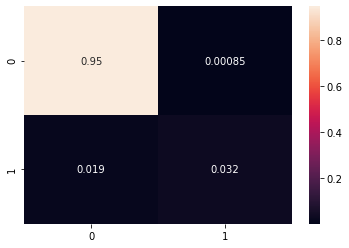

In [47]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True)